# Present data for EEA data portal

- Select results to show for 2021
- Merge results from 2020 where relevant, e.g. for pre-2000 data trends using lower resolution
- Figure out relevant visualisation focusing on inequality topic for 2021 report - especially wrt HDI class trends
- TODO decide what parameters you actually keep - don't need to lug around every indicator! e.g. focus on heawave counts and days totals
- Extract single values where needed, e.g. baseline HW numbers (**they always ask this**)

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [3]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [4]:
MAX_YEAR = 2020
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2021'

COUNTRY_SHAPEFILE = Path('~').expanduser() / 'Documents' / 'Lancet'/ 'Standardisation guidelines - LIVE FOR AUTHORS' / 'Shapefiles' / 'detailed_2013.shp'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [5]:
MAP_PROJECTION = ccrs.EckertIII()

## Load basic country data

In [6]:
countries = gpd.read_file(COUNTRY_SHAPEFILE)

In [7]:
# # Some things use the numeric code as an int instead of 0 padded 3 digit code
# countries['iso_n_int'] = countries.iso_n3.str.lstrip('0').astype(int)

In [8]:
countries = countries.set_index('ISO_3_CODE')

In [26]:
# countries

## Load EU/EEA data

In [10]:
# Outdata EEA CSV from 2014
eea = pd.read_csv('iso3166_alpha2_codes.csv')

In [32]:
extra_countries = ['Czech Republic', 'Liechtenstein', 'Luxembourg', 'Slovakia', 'Turkey', 
#                    'Kosovo', 
                   'Montenegro']

In [42]:
eea = pd.concat([eea ,(countries
       .reset_index()
       .set_index('SOVEREIGN')
       .loc[extra_countries]
       .reset_index()[['SOVEREIGN', 'ISO_2_CODE']]
       .rename(columns={'SOVEREIGN': 'Country name', 'ISO_2_CODE':'ISO2'}))])

In [43]:
eea = eea.set_index('ISO2').join(countries.reset_index().set_index('ISO_2_CODE')[['ISO_3_CODE']])

In [44]:
eea

Country name ISO_3_CODE
AL                                    Albania        ALB
AT                                    Austria        AUT
BA                     Bosnia and Herzegovina        BIH
BE                                    Belgium        BEL
BG                                   Bulgaria        BGR
CH                                Switzerland        CHE
CY                                     Cyprus        CYP
CZ                             Czech Republic        CZE
DE                                    Germany        DEU
DK                                    Denmark        DNK
EE                                    Estonia        EST
ES                                      Spain        ESP
FI                                    Finland        FIN
FR                                     France        FRA
GR                                     Greece        GRC
HR                                    Croatia        HRV
HU                                    Hungary        HUN
IE                                    Ireland        IRL
IS                                    Iceland        ISL
IT                                      Italy        ITA
LI                              Liechtenstein        LIE
LT                                  Lithuania        LTU
LU                                 Luxembourg        LUX
LV                                     Latvia        LVA
ME                                 Montenegro        MNE
MK  The former Yugoslav Republic of Macedonia        MKD
MT                                      Malta        MLT
NL                                Netherlands        NLD
NO                                     Norway        NOR
PL                                     Poland        POL
PT                                   Portugal        PRT
RO                                    Romania        ROU
RS                                     Serbia        SRB
SE                                     Sweden        SWE
SI                                   Slovenia        SVN
SK                                   Slovakia        SVK
TR                                     Turkey        TUR

## Load the country exposure results

In [47]:
exposure_results = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_change_2000-{MAX_YEAR}.nc')

In [48]:
exposure_results

<xarray.Dataset>
Dimensions:               (country: 248, year: 21)
Coordinates:
  * year                  (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'UMI' 'KOS'
Data variables:
    heatwave_mean_length  (country, year) float32 ...
    heatwaves_counts      (country, year) float64 ...
    heatwaves_days        (country, year) float64 ...

In [49]:
exposure_results = exposure_results.sel(country=eea.ISO_3_CODE.to_numpy())

In [50]:
eea_hw = exposure_results.sel(country=eea.ISO_3_CODE.to_numpy()).heatwaves_counts.to_dataframe().reset_index()

eea_hw = eea_hw.rename(columns={'heatwaves_counts': 'exposure of vulnerable population change in number of heatwaves'})

In [51]:
eea_hw.set_index(['year', 'country']).unstack().plot(legend=False)

In [52]:
eea_hw_days = exposure_results.sel(country=eea.ISO_3_CODE.to_numpy()).heatwaves_days.to_dataframe().reset_index()

eea_hw_days = eea_hw_days.rename(columns={'heatwaves_counts': 'exposure of vulnerable population change in number of heatwaves'})

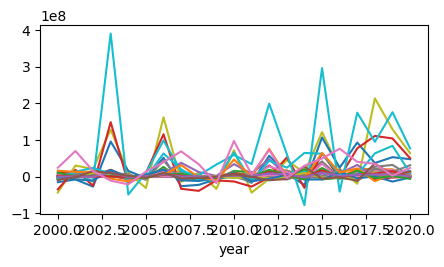

In [53]:
eea_hw_days.set_index(['year', 'country']).unstack().plot(legend=False)

## Load country weighted mean heatwave

In [54]:
weighted_results = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_weighted_change_2000-{MAX_YEAR}.nc')

In [55]:
weighted_results

<xarray.Dataset>
Dimensions:               (country: 248, year: 21)
Coordinates:
  * year                  (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'UMI' 'KOS'
Data variables:
    heatwave_mean_length  (country, year) float32 ...
    heatwaves_counts      (country, year) float64 ...
    heatwaves_days        (country, year) float64 ...

In [56]:
eea_hw_normalised = weighted_results.sel(country=eea.ISO_3_CODE.to_numpy()).heatwaves_counts.to_dataframe().reset_index()

eea_hw_normalised = eea_hw_normalised.rename(columns={'heatwaves_counts': 'vulnerable population wieghted change in number of heatwaves'})

In [57]:
eea_hw_normalised

country  year  \
0       ALB  2000   
1       ALB  2001   
2       ALB  2002   
3       ALB  2003   
4       ALB  2004   
..      ...   ...   
772     TUR  2016   
773     TUR  2017   
774     TUR  2018   
775     TUR  2019   
776     TUR  2020   

     vulnerable population wieghted change in number of heatwaves  
0                                            -0.031644             
1                                             0.788845             
2                                            -0.394412             
3                                             3.212945             
4                                            -0.610024             
..                                                 ...             
772                                           1.805658             
773                                           1.219493             
774                                           1.095126             
775                                           0.336229             
776                                           0.849824             

[777 rows x 3 columns]

In [58]:
eea_hw_normalised.to_csv(RESULTS_FOLDER / 'EEA vulnerable population wieghted change in number of heatwaves.csv', index=False)

In [59]:
eea_hw_normalised.set_index(['year', 'country']).unstack().plot(legend=False)

# Plot exposures as a stacked graph highlighting the main countries/regions

Get a rough calculation of the 'top' countries using the latest 10 year average (not just the last year to make it a bit fair)

In [20]:
exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_1980-{MAX_YEAR}.nc')

In [21]:
total_exposure_days = exposures.heatwaves_days.sum(dim=['latitude', 'longitude']).to_dataframe('exposures')

In [29]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = exposure_results[var].sel(year=slice(2000,MAX_YEAR)).mean(dim='year').to_dataframe().sort_values(by=var, ascending=False).head(5)[var].index.to_list()

# results = exposure_results[var].sel(country=top_codes).to_dataframe()[var].unstack().T
results = exposure_results[var].to_dataframe()[var].unstack().T

# # Difference between sum of top5 countries and total gives the 'other' category
# results['Other'] = total_exposure_days.exposures - results.sum(axis=1)
# # invert column order
# results = results[results.columns[::-1]]

In [ ]:
top_codes

In [32]:
with sns.color_palette("Paired"):
    f, ax = plt.subplots(figsize=(6.2, 2.5))
    (results / 1e9).plot.bar(stacked=True, 
                                  width=0.9, 
                                  label='Change relative to recent past average',
                             ax=ax,
                             legend=False
                            )
# plt.rcParams['figure.titlesize'] = 'medium'
# plt.rcParams['axes.titlesize'] = 'medium'
    ax.set(
        xlabel='Year',
        ylabel='Billion person-days',
        title='Exposure to change in heatwave days',
    )
    ax.xaxis.set_tick_params(labelsize='small')
    ax.yaxis.set_tick_params(labelsize='small')
#     ax.yaxis.label.set(size='medium')
    
    # Manually order the legend
#     handles, labels = ax.get_legend_handles_labels()
#     d = dict(zip(labels, handles))
#     ordered_labels = ['Italy', 'Germany', 'France', 'Poland', 'Indonesia', 'Rest of World']
#     iso_codes = ['ITA', 'DEU', 'FRA', 'POL', 'ESP']

#     ordered_handles = [d[l] for l in iso_codes]
#     ax.legend(ordered_handles, ordered_labels, fontsize='small')
#     ax.legend()
#     f.savefig(RESULTS_FOLDER / f'hw_exposure_days_countries_1980-{MAX_YEAR}.png')
#     f.savefig(RESULTS_FOLDER / f'hw_exposure_days_countries_1980-{MAX_YEAR}.pdf')


In [41]:
exp_rolling = exposure_results[var].rolling({'year':10}, center=True).mean().to_dataframe(var)[var].unstack().T.dropna()

In [43]:
tot_rolling = total_exposure_days.rolling(10, center=True).mean().dropna()

In [35]:
plot_data = exp_rolling[top_codes].copy()

plot_data['Other'] = tot_rolling.exposures - plot_data.sum(axis=1)
# invert column order
plot_data = plot_data[plot_data.columns[::-1]]

NameError: name 'exp_rolling' is not defined